# Zadanie 01 - Życie na krawędzi

### Deklaracja zmiennych

In [38]:
REDUCE_SIZE = 3
COLOR_AVG = [0.299, 0.587, 0.114]
GAUSSIAN_FILTER_SIZE = 5
SOBEL_X = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
SOBEL_Y = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
EDGE_THRESHOLD = 0.05

1. Zaczynamy od wczytania wybranego przez siebie obrazu. Nie ma potrzebny poddawania go na starcie intensywnej obróbce - upewnij się tylko, że można go użyć jako wejścia do zdefiniowanego dalej potoku przetwarzania. Warto jedynie przeskalować wszystkie wartości w pikselach tak, by mieściły się w zakresie od 0 do 1 (zwykle wystarczy podzielić je przez 255).

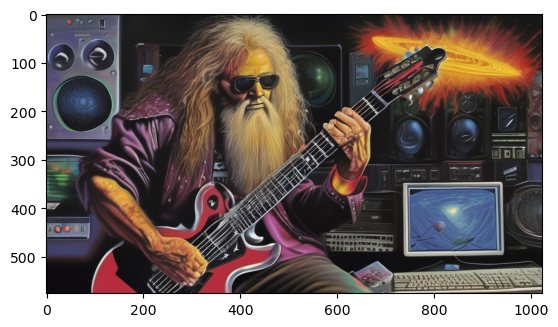

In [39]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

img = cv2.imread('pic.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

2. Obraz jest kolorowy i składa się z trzech kanałów - czerwonego, zielonego i niebieskiego. Dla uproszczenia późniejszych kroków zamieńmy go na wariant korzystający ze skali szarości - czyli składający się tylko z jednego kanału.

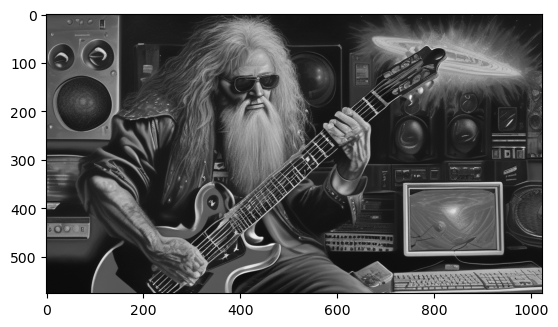

In [40]:
import torch

reduce_color = torch.tensor(COLOR_AVG)
img = torch.tensor(img, dtype=torch.float32) / 255
img = img @ reduce_color

plt.imshow(img, cmap='gray')

3. Obraz jest nieco za duży. Chociaż nie jest to praktyczne podejście do tego problemu, postaramy się zmniejszyć jego rozmiar z użyciem tzw. **poolingu** - operacji, która zastępuje każde okno o zadanym kształcie jednym nowym pikselem.

Tutaj wybieramy AvgPool2d, brzmi jak bezpieczniejsza opcja odporna na pixele o mocno odbiegającej wartości.

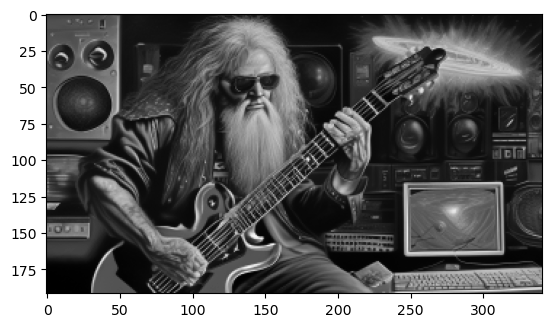

In [41]:
reduce_size = torch.nn.AvgPool2d(REDUCE_SIZE)

img = img.unsqueeze(0).unsqueeze(0)
img = reduce_size(img)
img = img.squeeze()

plt.imshow(img, cmap='gray')

4. Obraz jest już mały i czarno-biały, teraz pora pozbyć się niepotrzebnych szumów i detali. W tym celu zastosujemy rozmycie gaussowskie.

$$H_{ij}=\frac{1}{2\pi\sigma^2}\cdot\exp{\left(-\frac{(i - (k + 1))^2 + (j - (k + 1)^2)}{2\sigma^2}\right)} \hspace{0.3cm} \text{dla} \hspace{0.3cm} 1\lt i, j\lt(2k + 1)$$

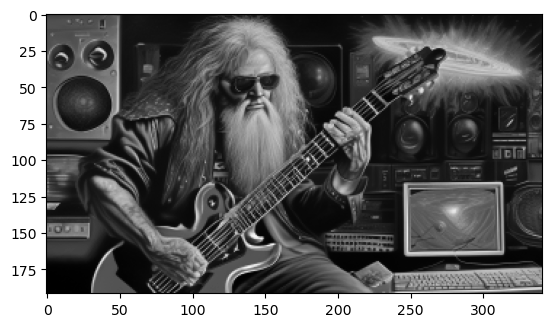

In [42]:
def gaussian_filter(size):
    x = torch.arange(-size, size+1, dtype=torch.float32)
    x = torch.exp(-(x ** 2) / (2 * (size ** 2)))
    x = x / x.sum()
    return x

filter = gaussian_filter(size=GAUSSIAN_FILTER_SIZE)
filter = filter.unsqueeze(0)
filter = filter @ filter.t()

img = torch.nn.functional.conv2d(
    img.unsqueeze(0).unsqueeze(0),
    filter.unsqueeze(0).unsqueeze(0)
)
img = img.squeeze().squeeze()

plt.imshow(img, cmap='gray')

5. Kolejny etap to ustalenie, w których regionach obrazu gradient intensywności jest
największy.

Do tego wykorzystamy filtry Sobela, dla krawędzi poziomych $$S_X = \begin{bmatrix} 1 & 2 & 1 \\\ 0 & 0 & 0 \\\ -1 & -2 & -1 \end{bmatrix}$$, a dla krawędzi pionowych $$S_Y = \begin{bmatrix} 1 & 0 & -1 \\\ 2 & 0 & -2 \\\ 1 & 0 & -1 \end{bmatrix}$$

Następnie "moc" krawędzi wyznaczymy licząc $$|G| = \sqrt{S_X^2 + S_Y^2}$$

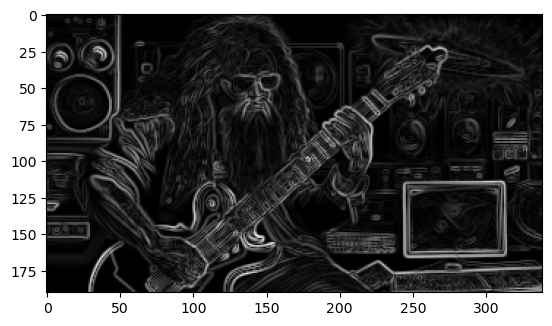

In [43]:
def sobel_filter_x():
    return torch.tensor(SOBEL_X, dtype=torch.float32)

def sobel_filter_y():
    return torch.tensor(SOBEL_Y, dtype=torch.float32)

filter_x = sobel_filter_x()
filter_y = sobel_filter_y()

img_x = torch.nn.functional.conv2d(
    img.unsqueeze(0).unsqueeze(0),
    filter_x.unsqueeze(0).unsqueeze(0)
)

img_y = torch.nn.functional.conv2d(
    img.unsqueeze(0).unsqueeze(0),
    filter_y.unsqueeze(0).unsqueeze(0)
)

img_angle = torch.sqrt(img_x ** 2 + img_y ** 2)

plt.imshow(img_angle.squeeze().squeeze(), cmap='gray')

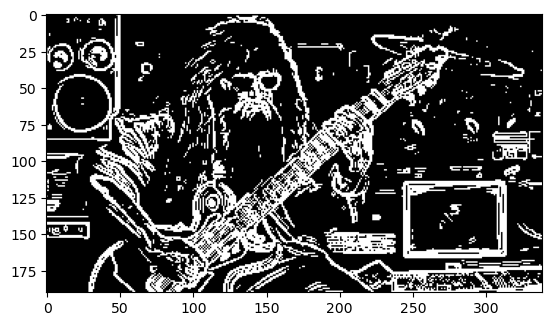

In [44]:
mask = torch.zeros_like(img_angle)
mask[img_angle > EDGE_THRESHOLD] = 1

plt.imshow(mask.squeeze().squeeze(), cmap='gray')

A ich kierunek licząc $$\theta = \tan{\left(\frac{S_X}{S_Y}\right)}$$

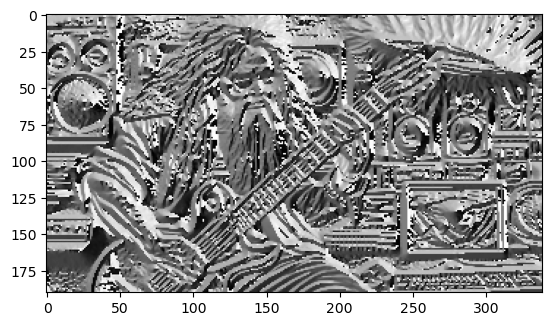

In [45]:
def edge_angle(x, y):
    return torch.atan2(y, x)

img_dir = edge_angle(img_x, img_y)

plt.imshow(img_dir.squeeze().squeeze(), cmap='gray')

6. Teraz zabierzemy się za "odchudzenie" wykrytych krok wcześniej krawędzi. Interesują nas tylko punkty o lokalnie największej intensywności (gdyby traktować intensywność gradientu jak wysokość nad poziomem morza, to w tym kroku szukalibyśmy odpowiednika grani). 

In [46]:
img_dir = img_dir[0, 0, :]
img_angle = img_angle[0, 0, :]

In [47]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255      
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0
            except IndexError as e:
                pass
    return Z